In [4]:
using NBInclude
@nbinclude("functions.ipynb")
function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    println("Done")
    return encoder_μ, encoder_logvar, decoder, decoder_last
    
end

function load_model_sep(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

All function imported


get_test_loader (generic function with 1 method)

In [2]:
# pick a image in MNIST to denoise
num = 3
batch_size = 64
shuffle_data = true
dataloader = get_test_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 30



dir_inco = "trained_GNN/MNIST_identity_v4"
encoder_μ_inco, encoder_logvar_inco, W1_inco, W2_inco, W3_inco, Q_inco = load_model_sep(dir_inco, epoch_to_load_inco);


# dir_inco = "trained_GNN/MNIST_identity_v2"
# encoder_μ_inco, encoder_logvar_inco, decoder, decoder_last = load_model_identity(dir_inco, epoch_to_load_inco);


μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)

# Load the model and test set loader unenforced
epoch_to_load_co = 30

dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, W1_co, W2_co, W3_co, Q_co = load_model_sep(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)

#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 5000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

# G_inco(z) = decoder_last * decoder(z)
G_inco(z) =Q_inco *W3_inco*relu(W2_inco*relu(W1_inco*z))
G_co(z) = Q_co*relu(W2_co*relu(W1_co*z))

plot(plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' )), plot(colorview(Gray, reshape(G_co(z_co), 28,28)' )), plot(colorview(Gray, reshape(x_true, 28,28)' )) )

LoadError: UndefVarError: get_test_loader not defined

In [3]:
k = 20
m_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250];
batch_size = 64
shuffle_data = true

z_co_list = zeros(9, k)
z_inco_list = zeros(9, k)
x_true_list = zeros(9, 784)
z_est_inco_matrix = zeros(9, k, length(m_list))
z_est_co_matrix = zeros(9, k, length(m_list))

Threads.@threads for num in 1:9
    dataloader = get_test_loader(batch_size, shuffle_data)
    (x_batch, y_batch) = first(dataloader)
    i = 1
    while y_batch[i] != num
    i += 1
    end
    x_true= x_batch[:, i];

    z_est_inco_list = zeros(k, length(m_list))
    z_est_co_list = zeros(k, length(m_list))
    x_true_list[num,:] = x_true

    # Apply reparameterisation trick to sample latent
    μ = encoder_μ_inco(x_true)
    logvar_inco = encoder_logvar_inco(x_true)
    z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)
    z_inco_list[num,:] = z_inco

    μ = encoder_μ_co(x_true)
    logvar_co = encoder_logvar_co(x_true)
    # Apply reparameterisation trick to sample latent
    z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)
    z_co_list[num,:] = z_co

     for i in 1:length(m_list)
        m = m_list[i]
        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

        y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
        z_est_inco = randn(k) #initialization for algorithm
        z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        z_est_inco_list[:,i] = z_est_inco

        y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
        z_est_co = randn(k) #initialization for algorithm
        z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        z_est_co_list[:,i] = z_est_co
    end

    z_est_inco_matrix[num,:,:] = z_est_inco_list
    z_est_co_matrix[num,:,:] = z_est_co_list

end





LoadError: TaskFailedException

[91m    nested task error: [39mUndefVarError: get_test_loader not defined
    Stacktrace:
     [1] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90;4mIn[3]:13[0m[90m [inlined][39m
     [2] [0m[1m(::var"#798#threadsfor_fun#1"{UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:81[0m
     [3] [0m[1m(::var"#798#threadsfor_fun#1"{UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:48[0m

In [100]:
save("saved_data/MNIST_image_recovery_30.jld", "z_inco_list", z_inco_list, "z_co_list", z_co_list, "x_true_list", x_true_list, "z_est_inco_matrix", z_est_inco_matrix, "z_est_co_matrix", z_est_co_matrix, "epoch", epoch, "m_list", m_list)

┌ Info: Saved animation to 
│   fn = /var/folders/p2/smmnhqzd3blf_bqyb4fp8b5h0000gn/T/jl_ijiH5V.gif
└ @ Plots /Users/babhru/.julia/packages/Plots/E2187/src/animation.jl:126


Plots.AnimatedGif("/var/folders/p2/smmnhqzd3blf_bqyb4fp8b5h0000gn/T/jl_ijiH5V.gif")
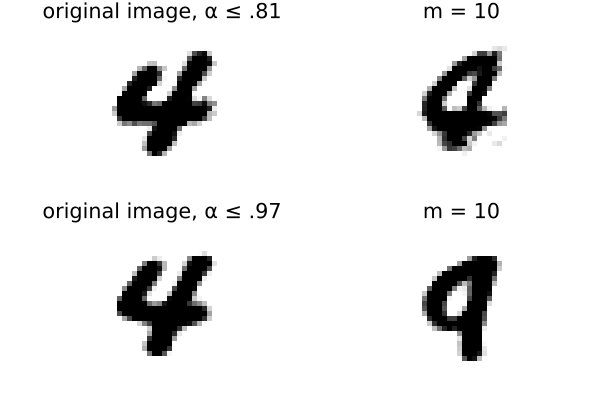

In [97]:
num = 4
epoch = 40
z_inco = z_inco_list[num, :]
z_co = z_co_list[num, :]
x_true = x_true_list[num, :]
z_est_inco_list = z_est_inco_matrix[num,:,:]
z_est_co_list = z_est_co_matrix[num,:,:]

anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end
gif(anim, fps = 1)
# colorview(Gray, reshape(x_true,28,28)')

# gif(anim, "anim_3.gif", fps = 1)

9×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [16]:
_,s,_, =svd(Q_inco);
println("$(minimum(G_inco(rand(20)))), $(maximum(G_inco(z_inco)))")
s
F = dct(diagm(ones(784)),2);
subspace_incoherence(F,Q_inco)
# # plot(plot(colorview(Gray, reshape(G_inco(rand(20)), 28,28)' )), plot(colorview(Gray, reshape(x_true, 28,28)' )) )

sum(G_inco(z_inco))/784

y1 = F_sub * G_inco(z)

y2 = F_sub * x_true


norm(y2)

-0.4473692276202767, 21.503749392356273


9.608543012030701

3.4799891579891775, 4.2686048, 4.2686048

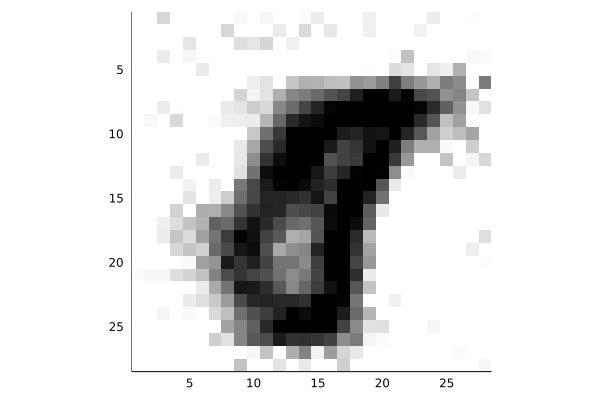

In [29]:
z = randn(20)
z = z_inco
m = 50
F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  
β = 1

# G = Chain(
#     Dense(20, 500, relu, bias = false; init =(out,in) -> β *W1_co + (1-β) * W1_inco),
#     Dense(500, 500, relu, bias = false; init =(out,in) -> β *W2_co + (1-β) * W2_inco),
#     Dense(500, 784, identity, bias = false; init =(out,in) -> β *W3_co + (1-β) * W3_inco),
# )  
opt = Flux.Optimise.ADAM(.1);
y =   2 * F_sub * x_true

# y = F_sub * G_inco(z) #measurement vector using subsampled DCT matrix
z_est = randn(k) #initialization for algorithm
z_est= estimated_code(opt, G_inco, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

print("$(relative_error(z,z_est)), $(norm(z)), $(norm(z_inco))")
plot(colorview(Gray, reshape(G_inco(z_est), 28,28)' ))

In [7]:
G_inco(randn(20))

784-element Vector{Float64}:
 4.011323968156594
 5.233803762769512
 3.1120401459278044
 2.8568457448944202
 5.200350988924232
 3.60723720786751
 5.675969222532749
 5.430950980683476
 3.180040878508641
 5.158292781867386
 ⋮
 6.324136741477455
 4.027624878749289
 3.9223933643682534
 3.8087554105146935
 3.7753126736593754
 3.6339933070056736
 3.720878059290229
 5.784969684707993
 2.7088833876236977

In [180]:
z_est

-2.2055735588469476

In [177]:
G_inco(z_est)

784×20 Matrix{Float64}:
 2.06729  4.24856   2.84978  0.0904797  …  2.40826  2.23028  0.0903554
 3.14459  2.5063    3.79747  0.112573      1.98289  2.59994  0.0725872
 1.50591  2.82442   4.00591  0.141563      1.92522  2.42991  0.0910964
 1.36083  3.345     2.42509  0.0716984     1.93192  2.08619  0.0875236
 2.71128  1.21192   4.69467  0.0841948     1.66022  3.27674  0.0956945
 2.90765  3.66576   4.08623  0.0680728  …  2.40235  2.68457  0.0883188
 2.79125  4.04288   4.74447  0.14465       3.09189  2.91107  0.13258
 2.92112  4.23556   5.67987  0.0823218     3.20681  4.09004  0.14648
 2.15779  1.87794   4.13693  0.079786      1.21045  2.1285   0.0629367
 3.71134  2.44968   3.13394  0.112494      2.63179  2.01133  0.117481
 ⋮                                      ⋱                    
 2.83314  0.922631  5.97547  0.139591   …  2.34405  1.7427   0.128346
 2.32092  2.47273   3.34934  0.0991562     1.98423  1.26069  0.0654815
 1.86803  5.39095   5.78655  0.0874076     3.71299  3.87385  0.02715

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


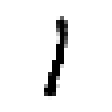

In [85]:


# pick a image in MNIST to denoise
num = 1
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)

# Load the model and test set loader unenforced
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)
colorview(Gray, reshape(G_co(z_co), 28,28)' )




┌ Info: Saved animation to 
│   fn = C:\Users\Babhru\AppData\Local\Temp\jl_Jyv6DWb3rh.gif
└ @ Plots C:\Users\Babhru\.julia\packages\Plots\E2187\src\animation.jl:126


Plots.AnimatedGif("C:\\Users\\Babhru\\AppData\\Local\\Temp\\jl_Jyv6DWb3rh.gif")
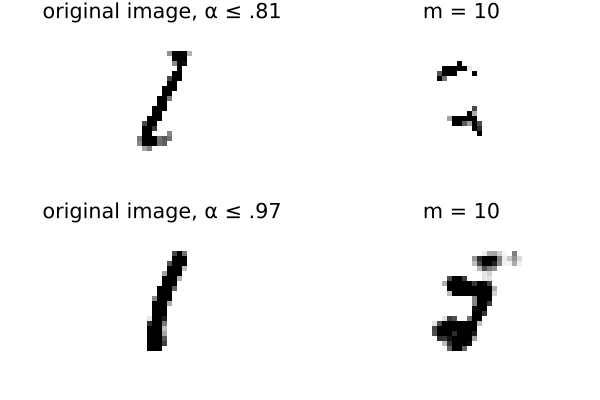

In [8]:
m_list = [10, 15, 20, 25, 50, 75, 100, 125, 150, 200, 300, 400];
z_est_inco_list_1 = zeros(k, length(m_list))
z_est_co_list_1 = zeros(k, length(m_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_inco_list_1[:,i] = z_est_inco

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_co_list_1[:,i] = z_est_co
end

anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list_1[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list_1[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end
gif(anim, fps = 1)
# gif(anim, "anim_$num.gif", fps = 1)


┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


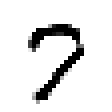

In [88]:


# pick a image in MNIST to denoise
num = 7
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)

# Load the model and test set loader unenforced
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)
colorview(Gray, reshape(G_co(z_co), 28,28)' )


┌ Info: Saved animation to 
│   fn = C:\Users\Babhru\AppData\Local\Temp\jl_dGSRp1U8nl.gif
└ @ Plots C:\Users\Babhru\.julia\packages\Plots\E2187\src\animation.jl:126


Plots.AnimatedGif("C:\\Users\\Babhru\\AppData\\Local\\Temp\\jl_dGSRp1U8nl.gif")
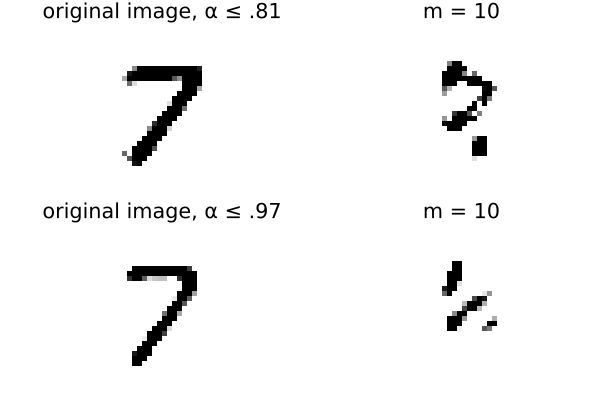

In [10]:
m_list = [10, 15, 20, 25, 50, 75, 100, 125, 150, 200, 300, 400];
z_est_inco_list_7 = zeros(k, length(m_list))
z_est_co_list_7 = zeros(k, length(m_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_inco_list_7[:,i] = z_est_inco

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_co_list_7[:,i] = z_est_co
end

anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list_7[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list_7[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end
gif(anim, fps = 1)
# gif(anim, "anim_$num.gif", fps = 1)


┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


Loading model...Done
Loading model...Done


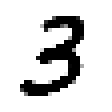

In [39]:


# pick a image in MNIST to denoise
num = 3
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)


# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, decoder_co, W3_co = load_model_identity(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)


#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

G_inco(z) = W3_inco *decoder_inco(z)
G_co(z) = W3_co *decoder_co(z)
colorview(Gray, reshape(G_co(z_co), 28,28)' )




In [40]:
m_list = 10:5:100
z_est_inco_list = zeros(k, length(m_list))
z_est_co_list = zeros(k, length(m_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_inco_list[:,i] = z_est_inco

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_co_list[:,i] = z_est_co
end



┌ Info: Saved animation to 
│   fn = c:\Users\Babhru\Documents\GitHub\GNN_Isometries\anim_3.gif
└ @ Plots C:\Users\Babhru\.julia\packages\Plots\E2187\src\animation.jl:126


Plots.AnimatedGif("c:\\Users\\Babhru\\Documents\\GitHub\\GNN_Isometries\\anim_3.gif")
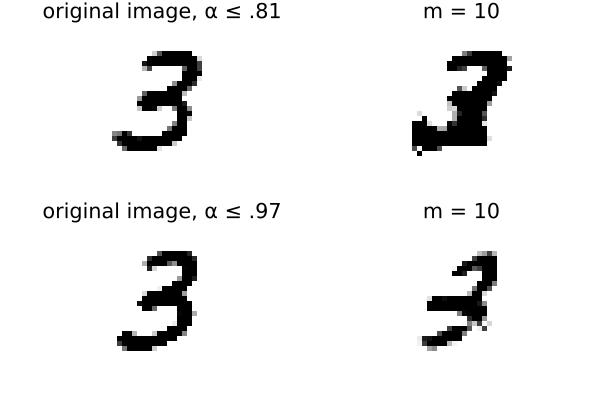

In [41]:
anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end

gif(anim, "anim_$num.gif", fps = 1)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


Loading model...Done
Loading model...Done


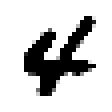

In [56]:


# pick a image in MNIST to denoise
num = 4
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)


# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, decoder_co, W3_co = load_model_identity(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)


#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

G_inco(z) = W3_inco *decoder_inco(z)
G_co(z) = W3_co *decoder_co(z)
colorview(Gray, reshape(G_co(z_co), 28,28)' )




┌ Info: Saved animation to 
│   fn = c:\Users\Babhru\Documents\GitHub\GNN_Isometries\anim_4.gif
└ @ Plots C:\Users\Babhru\.julia\packages\Plots\E2187\src\animation.jl:126


Plots.AnimatedGif("c:\\Users\\Babhru\\Documents\\GitHub\\GNN_Isometries\\anim_4.gif")
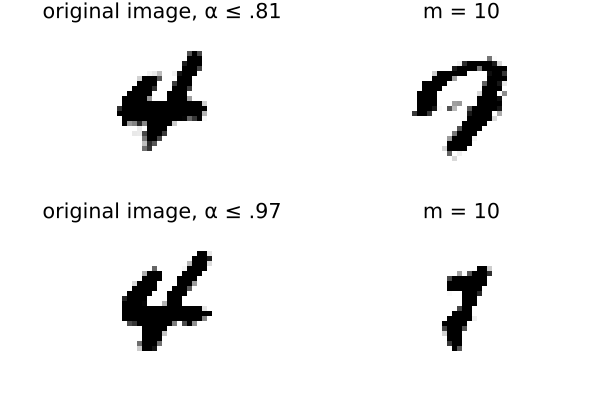

In [57]:
m_list = 10:5:100
z_est_inco_list = zeros(k, length(m_list))
z_est_co_list = zeros(k, length(m_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_inco_list[:,i] = z_est_inco

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_co_list[:,i] = z_est_co
end

anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end

gif(anim, "anim_$num.gif", fps = 1)



In [64]:


# pick a image in MNIST to denoise
num = 4
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)
(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ1 = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ1 + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco);


┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


Loading model...Done


In [9]:


# pick a image in MNIST to denoise
num = 9
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)
(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ2 = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ2 + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco);

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


Loading model...Done


In [8]:
norm(z_inco)

4.3862915f0

In [6]:
sqrt(20)

4.47213595499958

In [84]:
Threads.nthreads()

12